In [28]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [87]:
# Define paths
train_path = "Dataset/Data/train"
val_path = "Dataset/Data/val"
test_path = "Dataset/Data/test"

In [90]:
categories = ['Normal', 'Pneumonia']

In [88]:
import os

def count_images(directory):
    categories = [category for category in os.listdir(directory) if os.path.isdir(os.path.join(directory, category))]
    counts = {category: len(os.listdir(os.path.join(directory, category))) for category in categories}
    return counts


In [95]:
train_counts = count_images(train_path)
val_counts = count_images(val_path)
test_counts = count_images(test_path)

In [96]:
print("Train Data Distribution:", train_counts)
print("Validation Data Distribution:", val_counts)
print("Test Data Distribution:", test_counts)

Train Data Distribution: {'PNEUMONIA': 3876, 'NORMAL': 1342}
Validation Data Distribution: {'PNEUMONIA': 9, 'NORMAL': 9}
Test Data Distribution: {'PNEUMONIA': 390, 'NORMAL': 234}


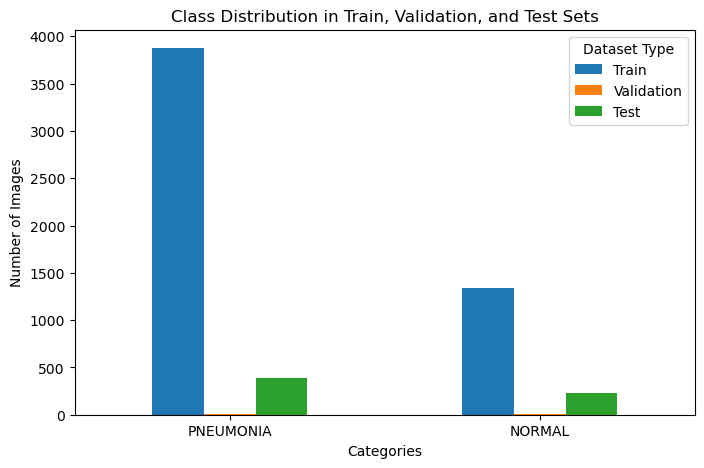

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame([train_counts, val_counts, test_counts], index=['Train', 'Validation', 'Test'])

# Plot
df.T.plot(kind='bar', figsize=(8,5))
plt.title("Class Distribution in Train, Validation, and Test Sets")
plt.ylabel("Number of Images")
plt.xlabel("Categories")
plt.xticks(rotation=0)
plt.legend(title="Dataset Type")
plt.show()

In [29]:
IMAGE_SIZE = [224, 224]

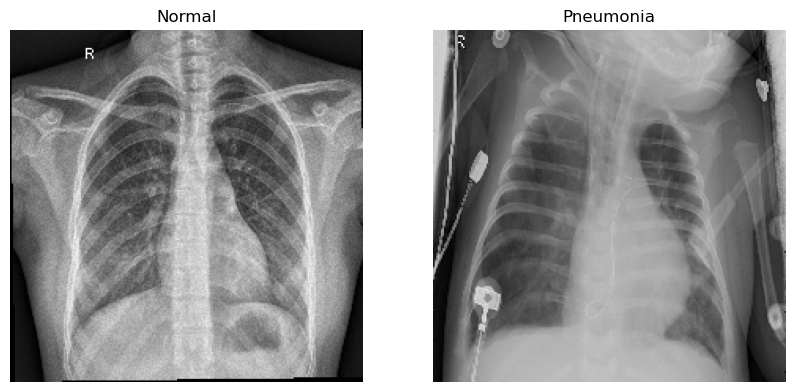

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, category in enumerate(categories):
    image_path = glob(os.path.join(train_path, category, '*.jpeg'))[0]
    img = load_img(image_path, target_size=IMAGE_SIZE)
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')
plt.show()

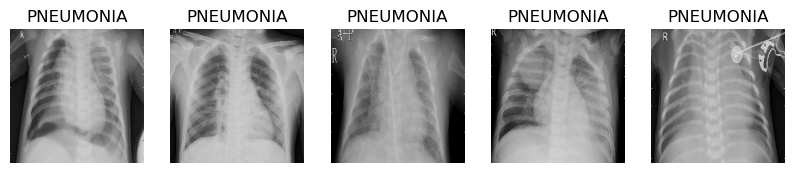

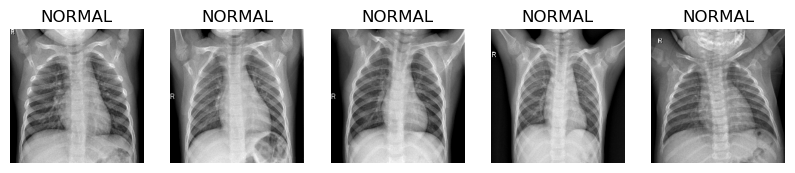

In [98]:
import random
import cv2
from keras.preprocessing.image import load_img

def show_sample_images(directory, class_name, num_samples=5):
    image_paths = os.listdir(os.path.join(directory, class_name))
    image_paths = random.sample(image_paths, num_samples)

    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(image_paths):
        img_path = os.path.join(directory, class_name, img_name)
        img = load_img(img_path, target_size=(224, 224))
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(class_name)
    plt.show()

# Show random images from both classes
show_sample_images(train_path, "PNEUMONIA", 5)
show_sample_images(train_path, "NORMAL", 5)

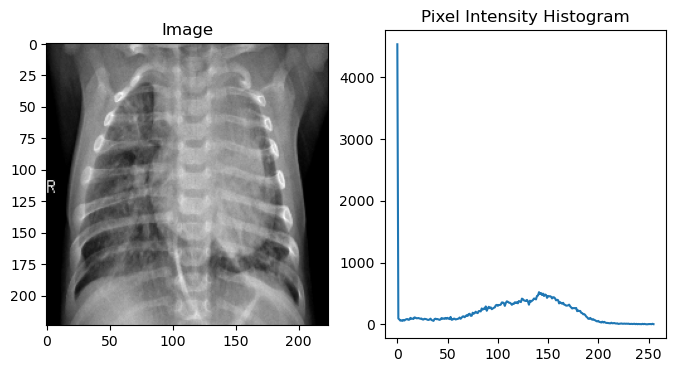

In [99]:
def plot_histogram(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])

    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap="gray")
    plt.title("Image")

    plt.subplot(1,2,2)
    plt.plot(hist)
    plt.title("Pixel Intensity Histogram")

    plt.show()

plot_histogram("Dataset/Data/test/PNEUMONIA/person100_bacteria_475.jpeg")

In [31]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [32]:
for layer in vgg.layers:
    layer.trainable = False

In [33]:
folders = glob('Dataset/Data/train/*')

In [34]:
x = Flatten()(vgg.output)

In [35]:
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
model = Model(inputs=vgg.input, outputs=prediction)

In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [37]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [38]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [39]:
training_set = train_datagen.flow_from_directory('Dataset/Data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [40]:
test_set = test_datagen.flow_from_directory('Dataset/Data/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [41]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=1,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/var/folders/_s/7_jh3nvd2xv2t52w6m622_rh0000gn/T/ipykernel_85077/1525006258.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


163/163 [==============================] - 6329s 39s/step - loss: 0.1765 - accuracy: 0.9298 - val_loss: 0.2288 - val_accuracy: 0.9279


In [62]:
r.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [61]:
r.history

{'loss': [0.17648987472057343],
 'accuracy': [0.9298312664031982],
 'val_loss': [0.22876358032226562],
 'val_accuracy': [0.9278846383094788]}

In [65]:
print("Loss:", r.history['loss'])
print("Validation Loss:", r.history['val_loss'])
print("Accuracy:", r.history['accuracy'])
print("Validation Accuracy:", r.history['val_accuracy'])

Loss: [0.17648987472057343]
Validation Loss: [0.22876358032226562]
Accuracy: [0.9298312664031982]
Validation Accuracy: [0.9278846383094788]


In [73]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_generator):
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function
# plot_confusion_matrix(model, test_set)

20/20 [==============================] - 614s 31s/step


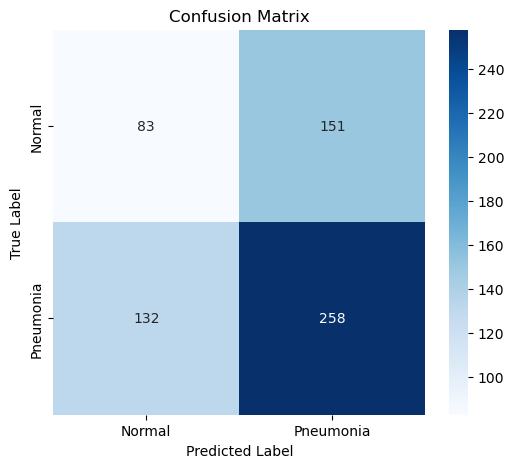

In [74]:
plot_confusion_matrix(model, test_set)

In [75]:
train_acc = r.history['accuracy'][-1]  # Last epoch training accuracy
val_acc = r.history['val_accuracy'][-1]  # Last epoch validation accuracy

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Training Accuracy: 92.98%
Validation Accuracy: 92.79%


In [76]:
from sklearn.metrics import classification_report, confusion_matrix

# Get ground truth labels
y_true = test_set.classes  

# Get model predictions
y_pred = np.argmax(model.predict(test_set), axis=1)  

# Generate classification report
report = classification_report(y_true, y_pred, target_names=categories)

print("Classification Report:\n", report)

20/20 [==============================] - 496s 24s/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.36      0.33      0.34       234
   Pneumonia       0.62      0.65      0.63       390

    accuracy                           0.53       624
   macro avg       0.49      0.49      0.49       624
weighted avg       0.52      0.53      0.52       624



In [101]:
!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/e5/a1/43bd69f32ddf381a09de18ea94d4b215d5ced3a24ff1a7b7d1a9401b5b85/shap-0.46.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.3/459.3 kB 5.1 MB/s eta 0:00:0000:0100:01


In [103]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,  # Path to test dataset
    target_size=(224, 224),
    batch_size=1,  # One image at a time
    class_mode="categorical",
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [43]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

model.save('model_vgg16.h5')

/Users/apple/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [106]:
from keras.models import load_model

# Load the trained model
model = load_model('model_vgg16.h5')

# Verify the model summary to confirm it's loaded correctly
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [78]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

categories = ['Normal', 'Pneumonia']

def predict_sample(image_path, model):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Predict the class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    # Display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Predicted: {categories[predicted_class]}")
    plt.axis('off')
    plt.show()
    
    return categories[predicted_class]

1/1 [==============================] - 1s 1s/step


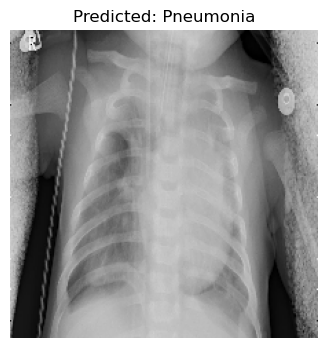

Pneumonia


In [79]:
print(predict_sample("Dataset/Data/test/PNEUMONIA/person100_bacteria_478.jpeg", model))

1/1 [==============================] - 1s 1s/step


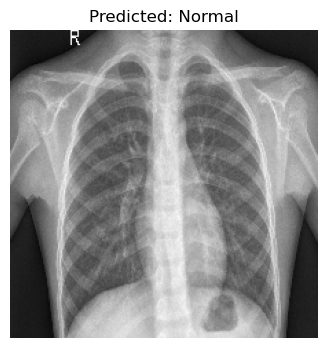

Normal


In [107]:
print(predict_sample("Dataset/Data/test/NORMAL/IM-0001-0001.jpeg", model))